In [1]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st


import itertools

2) Discrete Event Simulation

In [2]:
def Queue(env, n_persons, lambd, servers, waiting_times_list, serving_rate):
    """queue gets customers randomly"""
    for _ in range(n_persons):
        # person = Person(env, servers, waiting_times_list, serving_rate)
        # env.process(person)
        arrival_time = np.random.exponential(1.0/lambd)
        yield env.timeout(arrival_time)
        person = Person(env, servers, waiting_times_list, serving_rate)
        env.process(person)
        

def Person(env, servers, waiting_times_list, serving_rate):
    """People arrive, wait in queue, are served and leave."""
    arrive = env.now

    with servers.request() as req:
        yield req

        wait = env.now - arrive
        waiting_times_list.append(wait)

        serving_time = np.random.exponential(1.0/serving_rate)
        yield env.timeout(serving_time)

def run_simulation(lambd, n, mu, n_persons, waiting_times_list, runs, scheduling_type):
    env = simpy.Environment()
    serving_rate = mu
    for _ in range(runs):
        if scheduling_type == 'FIFO':
            servers = simpy.Resource(env, capacity=n)
        elif scheduling_type == 'SJF':
            servers = simpy.PriorityResource(env, capacity = n)
        else:
            raise ValueError('invalid scheduling type')
        env.process(Queue(env, n_persons, lambd, servers, waiting_times_list, serving_rate))
        env.run()

    return waiting_times_list


In [2]:
class Queue:
    def __init__(self,env,n_servers,rho,mu,scheduling_type = 'FIFO', service_distribution="M"):
        self.env = env
        self.scheduling_type = scheduling_type
        self.mu = mu
        self.rho = rho
        self.lambd = rho*(n_servers*mu)
        self.cust = 0
        self.arrival_time = 0
        self.service_start_time = 0
        self.service_distribution = service_distribution

        if scheduling_type == 'FIFO':
            self.server = simpy.Resource(env, capacity=n_servers)
        elif scheduling_type == 'SJF':
            self.server = simpy.PriorityResource(env,capacity=n_servers)

    def HyperVariate(self,p, m1, m2):
        rand = np.random.uniform()
        if rand < p:
            return random.expovariate(1.0 / m1)
        else:
            return random.expovariate(1.0 / m2)

    def arrive(self, n_customers,wait_times_list):
        while self.cust < n_customers:
            yield self.env.timeout(random.expovariate(self.lambd))
            self.cust+=1
            self.env.process(self.service(wait_times_list))
    
    def service(self, wait_times_list):
        if self.service_distribution == "M":
            serving_time = random.expovariate(self.mu) 

        elif self.service_distribution == "D":
            serving_time = 1/self.mu
        
        elif self.service_distribution == "H":
            serving_time = self.HyperVariate(0.75, 1, 5)

        else:
            raise ValueError("invalid distribution")

        self.arrival_time = self.env.now

        if self.scheduling_type == 'FIFO':
            with self.server.request() as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(serving_time)

        elif self.scheduling_type == 'SJF':
            with self.server.request(priority = serving_time) as req:
                yield req
                self.service_start_time = self.env.now
                wait_times_list.append(self.service_start_time - self.arrival_time)
                yield self.env.timeout(serving_time)
    
    def run_sim(self, n_customers):
        wait_times_list = []
        self.env.process(self.arrive(n_customers, wait_times_list))
        self.env.run()
        return wait_times_list
        

**Opdracht 2: n=1,2,4 en 3: SJF**

In [4]:
random.seed(3)
runs = 1000
n_customers = 500
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1 = []
wait_total_n2 = []
wait_total_n4 = []

wait_total_n1_sjf = []
wait_total_n2_sjf = []
wait_total_n4_sjf = []
for i in range(runs):
    MM1queue_fifo = Queue(env,1,rho,mu)
    MM2queue_fifo = Queue(env,2,rho,mu)
    MM4queue_fifo = Queue(env,4,rho,mu)
    
    wait_total_n1.extend(MM1queue_fifo.run_sim(n_customers))
    wait_total_n2.extend(MM2queue_fifo.run_sim(n_customers))
    wait_total_n4.extend(MM4queue_fifo.run_sim(n_customers))

    MM1queue_sjf = Queue(env,1,rho,mu, scheduling_type='SJF')
    MM2queue_sjf = Queue(env,2,rho,mu, scheduling_type='SJF')
    MM4queue_sjf = Queue(env,4,rho,mu, scheduling_type='SJF')
    
    wait_total_n1_sjf.extend(MM1queue_sjf.run_sim(n_customers))
    wait_total_n2_sjf.extend(MM2queue_sjf.run_sim(n_customers))
    wait_total_n4_sjf.extend(MM4queue_sjf.run_sim(n_customers))


In [16]:
# compare for different values of rho
random.seed(3)
runs = 100
n_customers = 50
rhos = np.arange(0.5,0.91,0.1)
mu = 1/2

env = simpy.Environment()

wait_total_n1_rhos = []
wait_total_n2_rhos = []
wait_total_n4_rhos = []

for rho in rhos:
    wait_n1_rho = []
    wait_n2_rho = []
    wait_n4_rho = []
    for _ in range(runs):
        MM1queue_rho = Queue(env,1,rho,mu)
        MM2queue_rho = Queue(env,2,rho,mu)
        MM4queue_rho = Queue(env,4,rho,mu)
        
        wait_n1_rho.extend(MM1queue_rho.run_sim(n_customers)) # take the mean here? only append mean? or do we not want to lose data?
        wait_n2_rho.extend(MM2queue_rho.run_sim(n_customers))
        wait_n4_rho.extend(MM4queue_rho.run_sim(n_customers))

    wait_total_n1_rhos.append(wait_n1_rho)
    wait_total_n2_rhos.append(wait_n2_rho)
    wait_total_n4_rhos.append(wait_n4_rho)

print(len(wait_total_n1_rhos))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
50
100
150
200
250
300
350
400
450
500
5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


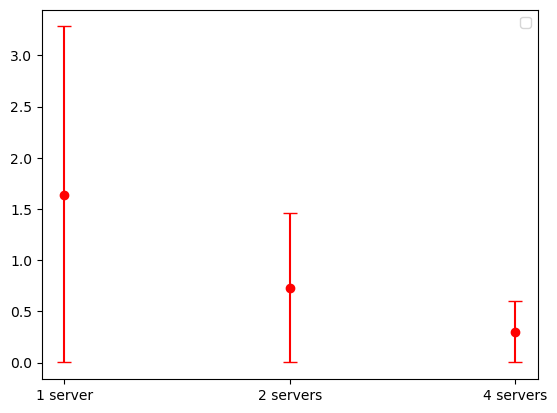

In [10]:
def plot_conf_95(waiting_times):
    mean = np.mean(waiting_times)
    
    confidence_interval =st.t.interval(confidence=0.95, df=len(waiting_times)-1, loc=mean, scale=st.sem(waiting_times))
    yerr = np.array([[confidence_interval[0], confidence_interval[1]]])
    return mean, yerr

m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

plt.errorbar(x=1, y=m1, yerr=yerr1.T, fmt='o', capsize=5, color = 'red')

plt.errorbar(x=2, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')

plt.errorbar(x=3, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')

plt.xticks([1, 2, 3], ['1 server', '2 servers', '4 servers'])
plt.legend()
plt.show()

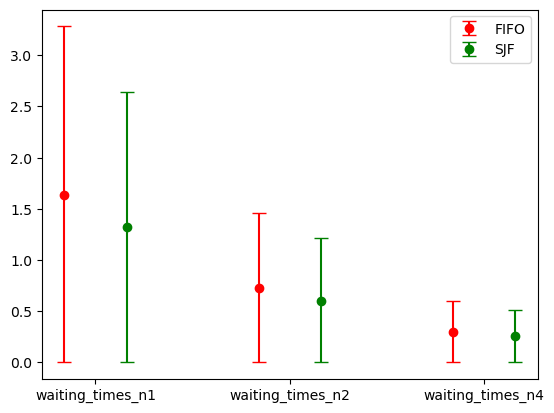

In [7]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='FIFO', color = 'red')
plt.errorbar(x=1+0.16, y=m1_sjf, yerr=yerr1_sjf.T, fmt='o', capsize=5, label='SJF', color = 'green')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2+0.16, y=m2_sjf, yerr=yerr2_sjf.T, fmt='o', capsize=5,color = 'green')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3+0.16, y=m4_sjf, yerr=yerr4_sjf.T, fmt='o', capsize=5,color = 'green')

plt.xticks([1, 2, 3], ['waiting_times_n1', 'waiting_times_n2', 'waiting_times_n4'])
plt.legend()
plt.show()

In [11]:
print(f"For a queue with in total {n_customers} people that get in the queue with system load {rho} for {runs} days:")
print(f"the mean waiting time was {np.mean(wait_total_n1)}, with a standard deviation of {np.std(wait_total_n1)}")
print(f"the mean waiting time was {np.mean(wait_total_n2)}, with a standard deviation of {np.std(wait_total_n2)}")
print(f"the mean waiting time was {np.mean(wait_total_n4)}, with a standard deviation of {np.std(wait_total_n4)}")

print(f"the mean waiting time sjf was {np.mean(wait_total_n1_sjf )}, with a standard deviation of {np.std(wait_total_n1_sjf )}")
print(f"the mean waiting time sjf was {np.mean(wait_total_n2_sjf )}, with a standard deviation of {np.std(wait_total_n2_sjf )}")
print(f"the mean waiting time sjf was {np.mean(wait_total_n4_sjf )}, with a standard deviation of {np.std(wait_total_n4_sjf )}")


For a queue with in total 50 people that get in the queue with system load 0.8 for 1000 days:
the mean waiting time was 1.8779934333685517, with a standard deviation of 3.195270365236774
the mean waiting time was 0.7588103378327345, with a standard deviation of 1.5341964646614832
the mean waiting time was 0.259452600043843, with a standard deviation of 0.5810800966273455
the mean waiting time sjf was 1.2678759753760922, with a standard deviation of 2.0586660243944777
the mean waiting time sjf was 0.5680044314906878, with a standard deviation of 0.9198411339342899
the mean waiting time sjf was 0.21282258562334447, with a standard deviation of 0.41889575560775943


opdracht 3: plot waiting times against number of customers with 4 servers

In [41]:
random.seed(3)
runs = 10
n_customers = 5
rho = 0.8
mu = 1/2

env = simpy.Environment()


waiting_times = []

waiting_times_sjf = []
for i in range(runs):
    MM4queue_fifo = Queue(env,4,rho,mu)

    waiting_times.append(MM4queue_fifo.run_sim(n_customers))

    MM4queue_sjf = Queue(env,4,rho,mu, scheduling_type='SJF')

    waiting_times_sjf.append(MM4queue_sjf.run_sim(n_customers))

**Opdracht 4**

In [27]:
random.seed(3)
runs = 100
n_customers = 50
rho = 0.8
mu = 1/2

env = simpy.Environment()

wait_total_n1_Det = []
wait_total_n2_Det = []
wait_total_n4_Det = []

wait_total_n1_Hexp = []
wait_total_n2_Hexp = []
wait_total_n4_Hexp = []


for i in range(runs):
    MD1queue_fifo = Queue(env,1,rho,mu, service_distribution="D")
    MD2queue_fifo = Queue(env,2,rho,mu, service_distribution="D")
    MD4queue_fifo = Queue(env,4,rho,mu, service_distribution="D")
    
    wait_total_n1_Det.extend(MD1queue_fifo.run_sim(n_customers))
    wait_total_n2_Det.extend(MD2queue_fifo.run_sim(n_customers))
    wait_total_n4_Det.extend(MD4queue_fifo.run_sim(n_customers))

    MH1queue_fifo = Queue(env,1,rho,mu, service_distribution="H")
    MH2queue_fifo = Queue(env,2,rho,mu, service_distribution="H")
    MH4queue_fifo = Queue(env,4,rho,mu, service_distribution="H")
    
    wait_total_n1_Hexp.extend(MH1queue_fifo.run_sim(n_customers))
    wait_total_n2_Hexp.extend(MH2queue_fifo.run_sim(n_customers))
    wait_total_n4_Hexp.extend(MH4queue_fifo.run_sim(n_customers))




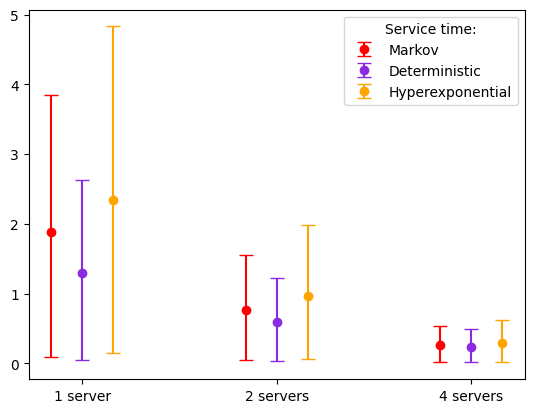

In [35]:
m1, yerr1 = plot_conf_95(wait_total_n1)
m2, yerr2 = plot_conf_95(wait_total_n2)
m4, yerr4 = plot_conf_95(wait_total_n4)

m1_sjf, yerr1_sjf = plot_conf_95(wait_total_n1_sjf)
m2_sjf, yerr2_sjf = plot_conf_95(wait_total_n2_sjf)
m4_sjf, yerr4_sjf = plot_conf_95(wait_total_n4_sjf)

m1_Det, yerr1_Det = plot_conf_95(wait_total_n1_Det)
m2_Det, yerr2_Det = plot_conf_95(wait_total_n2_Det)
m4_Det, yerr4_Det = plot_conf_95(wait_total_n4_Det)

m1_Hexp, yerr1_Hexp = plot_conf_95(wait_total_n1_Hexp)
m2_Hexp, yerr2_Hexp = plot_conf_95(wait_total_n2_Hexp)
m4_Hexp, yerr4_Hexp = plot_conf_95(wait_total_n4_Hexp)

plt.errorbar(x=1-0.16, y=m1, yerr=yerr1.T, fmt='o', capsize=5, label='Markov', color = 'red')
plt.errorbar(x=1, y=m1_Det, yerr=yerr1_Det.T, fmt='o', capsize=5, label='Deterministic', color = 'blueviolet')
plt.errorbar(x=1+0.16, y=m1_Hexp, yerr=yerr1_Hexp.T, fmt='o', capsize=5, label='Hyperexponential', color = 'orange')

plt.errorbar(x=2-0.16, y=m2, yerr=yerr2.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=2, y=m2_Det, yerr=yerr2_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=2+0.16, y=m2_Hexp, yerr=yerr2_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.errorbar(x=3-0.16, y=m4, yerr=yerr4.T, fmt='o', capsize=5,color = 'red')
plt.errorbar(x=3, y=m4_Det, yerr=yerr4_Det.T, fmt='o', capsize=5,color = 'blueviolet')
plt.errorbar(x=3+0.16, y=m4_Hexp, yerr=yerr4_Hexp.T, fmt='o', capsize=5,color = 'orange')

plt.xticks([1, 2, 3], ['1 server', '2 servers', '4 servers'])
plt.legend(title="Service time:")
plt.show()